In [1]:
import json
import time
import math
from datetime import datetime
import os
from tqdm import trange, tqdm
import re
from copy import deepcopy


import csv
import unicodedata
import html
from html.parser import HTMLParser
from io import StringIO


import pandas as pd
from pandas import DataFrame, Series
import numpy as np
from numpy import ndarray 
import matplotlib.pyplot as plt
import seaborn as sns



from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split



from nptyping import NDArray, Int, Shape
from typing import Dict, List, Tuple, Union




from piazza_api import Piazza
from piazza_api.network import Network

"""Custom Types"""
Answer = Dict[str,Dict[str,Union[str,int]]]
Post = Dict[str,Union[str, Union[str,int,List]]]

"""Macros"""
# who the answer is coming from
STUDENT, INSTRUCTOR, STUDENT_ENDORSED_ANSWERER = 0, 1, 2
EPSILON = 1e-05

DATASET_PATH = 'datasets/'


### Split into train and test datasets

In [2]:
# ANALYSIS_FILEPATH = "./csc108_fall2021_sentiment_aug.csv"
# final_data = pd.read_csv(ANALYSIS_FILEPATH).set_index('ID')

# y = final_data['is_helpful'] # labels

# raw augmented data before pruning features
CSC108_FALL2019_FILEPATH = './csc108_fall2019_sentiment_aug.csv'
CSC108_FALL2020_FILEPATH = './csc108_fall2020_sentiment_aug.csv'

CSC108_FALL2021_FILEPATH = './csc108_fall2021_sentiment_aug.csv'
# pruned features not useful for making predictions (i.e. question/answer poster id, post id)
TRAIN_FILEPATH = './datasets/train.csv'
VAL_FILEPATH = './datasets/val.csv'
TEST_FILEPATH = './datasets/test.csv'

train = pd.read_csv(TRAIN_FILEPATH)
val = pd.read_csv(VAL_FILEPATH)
test = pd.read_csv(TEST_FILEPATH)

csc108_fall2019 = pd.read_csv(CSC108_FALL2019_FILEPATH)
csc108_fall2020 = pd.read_csv(CSC108_FALL2020_FILEPATH)
csc108_fall2021 = pd.read_csv(CSC108_FALL2021_FILEPATH)




### Feature Distributions 

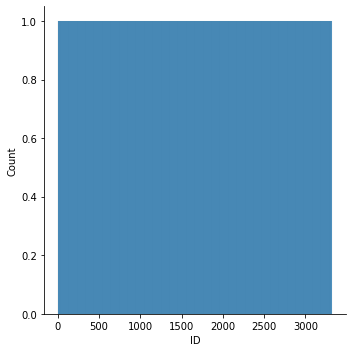

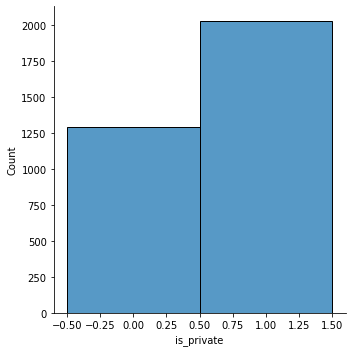

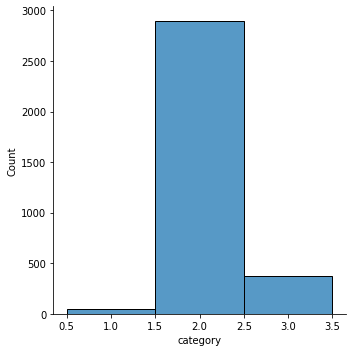

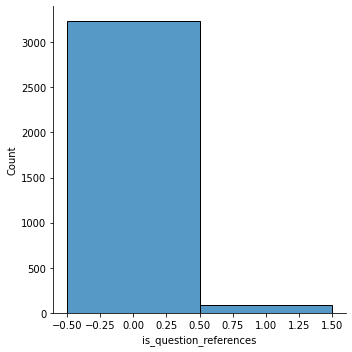

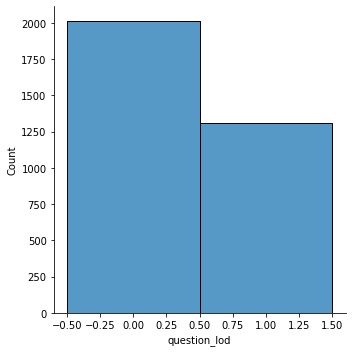

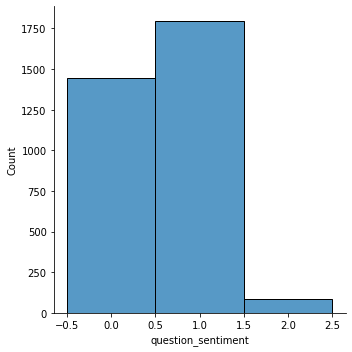

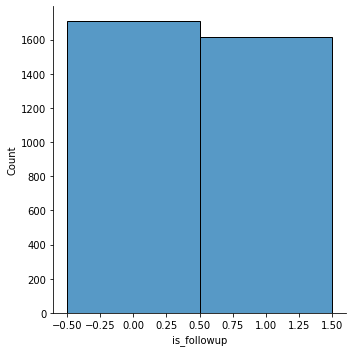

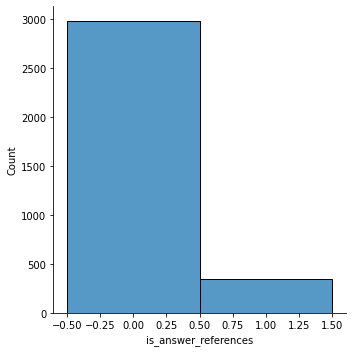

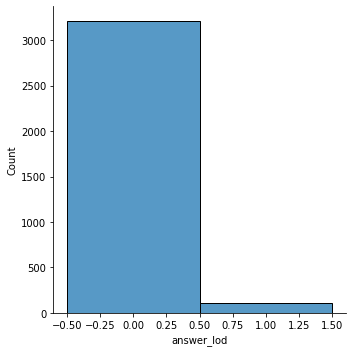

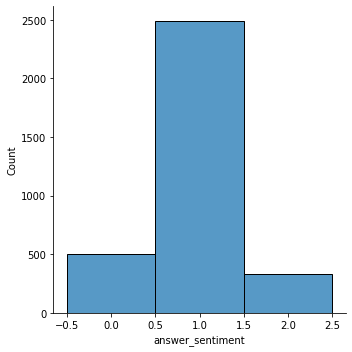

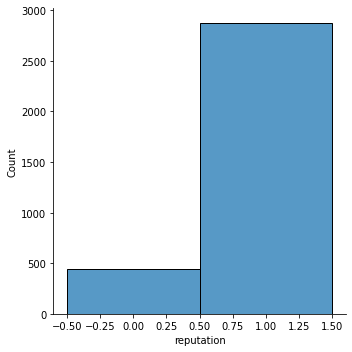

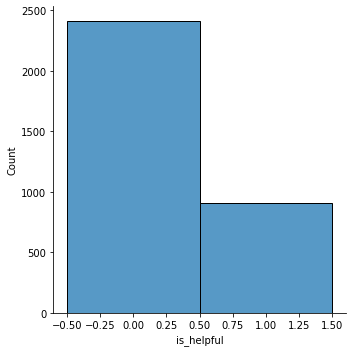

In [8]:
def plot_discrete_distributions(dataset: DataFrame, continuous_features: set, hue=None) -> None:
    """
    :param hue: None, is_helpful, set where set indicates the type of dataset
    :param continuous_features: Set of features to exclude from the plot.
    :param hue: Add a third dimension to the plot. Can set to "is_helpful".
    """
    features = dataset.keys()
    for f in features:
        if f not in continuous_features:
            if hue:
                sns.displot(data=dataset, x=f"{f}",  kind="hist", discrete=True, binwidth=1, hue=hue)
            else:
                sns.displot(data=dataset, x=f"{f}",  kind="hist", discrete=True, binwidth=1)

   

continuous_features = {'question_length', 'answer_length', 'response_time', 'post_id', 'student_poster_id', 'answerer_id'}

plot_discrete_distributions(csc108_fall2020, continuous_features, hue=None)

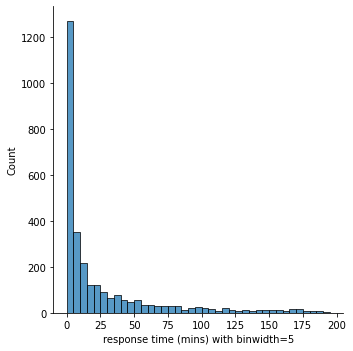

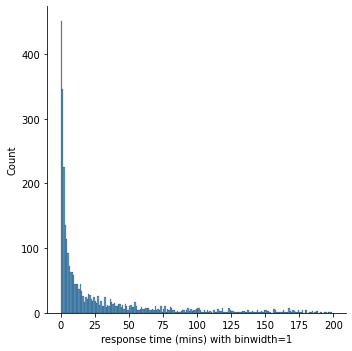

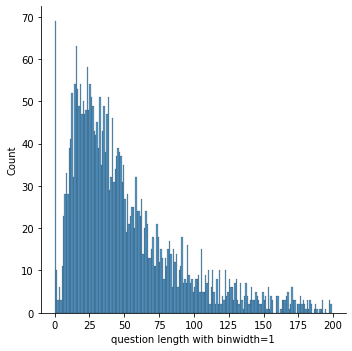

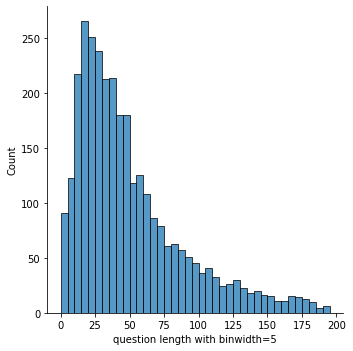

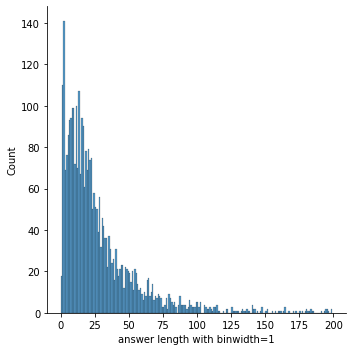

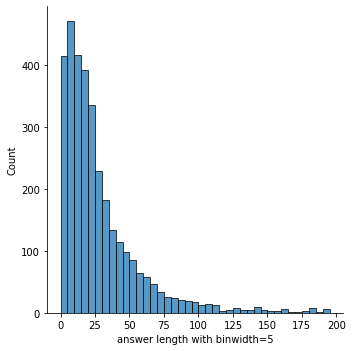

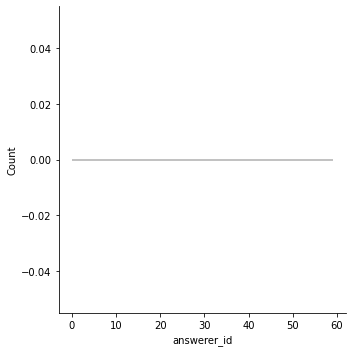

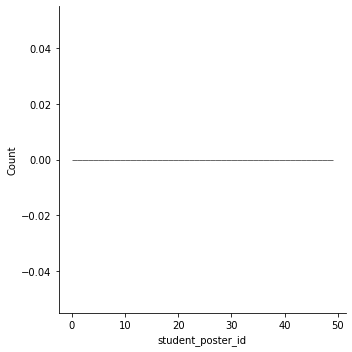

In [9]:
def plot_continuous_distributions(dataset: DataFrame, hue=None) -> None:

    a = np.arange(0, 200, 5)
    b = np.arange(0, 200, 1)

    ax = sns.displot(data=dataset, x=f"response_time",  kind="hist", bins=a, hue=hue)
    ax.set_xlabels('response time (mins) with binwidth=5')

    ax=sns.displot(data=dataset, x=f"response_time",  kind="hist", bins=b,hue=hue)
    ax.set_xlabels('response time (mins) with binwidth=1')

    c = np.arange(0, 200, 1)
    c1 = np.arange(0, 200, 5)

    ax=sns.displot(data=dataset, x=f"question_length",  kind="hist", bins=c,hue=hue)
    ax.set_xlabels('question length with binwidth=1')
    ax=sns.displot(data=dataset, x=f"question_length",  kind="hist", bins=c1, hue=hue)
    ax.set_xlabels('question length with binwidth=5')


    ax=sns.displot(data=dataset, x=f"answer_length",  kind="hist", bins=c,hue=hue)
    ax.set_xlabels('answer length with binwidth=1')
    ax=sns.displot(data=dataset, x=f"answer_length",  kind="hist", bins=c1,hue=hue)
    ax.set_xlabels('answer length with binwidth=5')

    d= np.arange(0, 60, 1)
    e= np.arange(0, 50, 1) # take random sampling of 50
    ax=sns.displot(data=dataset, x=f"answerer_id",  kind="hist", bins=d, hue=hue)
    ax=sns.displot(data=dataset, x=f"student_poster_id",  kind="hist", bins=e, hue=hue)

# add helpful as a 3rd axis
# check for rlnship b/w question/answerer and is/is not helpful
plot_continuous_distributions(csc108_fall2020, hue=None)

### Statistical Tests Performed Only on the Training Set

In [10]:
y_train = train['is_helpful']
X_train = train.drop(labels=["is_helpful"], axis=1)

y_val = val['is_helpful']
X_val = val.drop(labels=["is_helpful"], axis=1)

y_test = test['is_helpful']
X_test = test.drop(labels=["is_helpful"], axis=1)

X_train.keys()

Index(['is_private', 'category', 'question_length', 'is_question_references',
       'question_lod', 'question_sentiment', 'is_followup', 'answer_length',
       'is_answer_references', 'answer_lod', 'answer_sentiment',
       'response_time', 'reputation'],
      dtype='object')

mi feature names is: ['question_length', 'question_sentiment', 'is_followup', 'answer_length', 'is_answer_references', 'response_time']
mi score_indices is [2, 5, 6, 7, 8, 11]


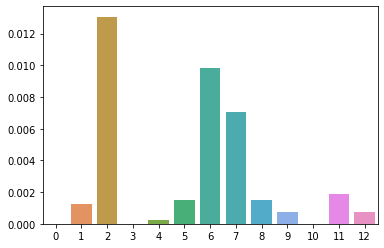

In [11]:
from functools import partial


def mutual_info_score():
    return 

def plot_scores(X_train, y_train, select_k_best='all', continuous_features:set=None, seed=0, score_func=mutual_info_classif):
    """
    Determine and plot MI scores b/w train data and targets. MI is useful since it works for both discrete and continuous features.
    Chi-squared test only makes sense for discrete, nominal (as opposed to ordinal) features.

    Can still run chi-squared on a subset of the features.
    """

    features = list(X_train.keys())

    if select_k_best == 'all':
        select_k_best = len(features)


    if score_func == mutual_info_classif:
        discrete_indices = list(range(0, len(features)))
        # Remove continuous index features: q&a length, response time, post id, student/answerer id
        for f in continuous_features:
            if f in features:
                discrete_indices.remove(features.index(f))

        score_func = partial(mutual_info_classif, discrete_features=discrete_indices, random_state=seed)
        #scores = score_func(X_train, y_train)
    #else: # chi2
       # scores = score_func(X_train, y_train)[0]


    select_k = SelectKBest(score_func, k=select_k_best).fit(X_train, y_train)
    scores = select_k.scores_
    support = select_k.get_support()


    scores = scores.tolist()
    sns.barplot(x=list(range(0, len(features))), y=scores)

    features = np.array(features)
    feature_indices = np.where(support)[0]
    feature_names = features[feature_indices]

    return list(feature_names), list(feature_indices)


mi_feature_names, mi_score_indices = plot_scores(X_train, y_train, continuous_features=continuous_features, select_k_best=6)
print(f"mi feature names is: {mi_feature_names}\nmi score_indices is {mi_score_indices}")


In [12]:
X_train.keys()

Index(['is_private', 'category', 'question_length', 'is_question_references',
       'question_lod', 'question_sentiment', 'is_followup', 'answer_length',
       'is_answer_references', 'answer_lod', 'answer_sentiment',
       'response_time', 'reputation'],
      dtype='object')

chi2 feature names is: ['question_lod', 'question_sentiment', 'is_followup', 'is_answer_references', 'answer_lod', 'reputation']
chi2 score_indices is [3, 4, 5, 6, 7, 9]


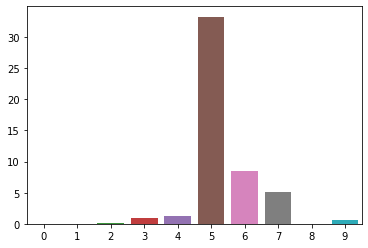

In [13]:
X_train_discrete = X_train.drop(list(continuous_features), axis=1, errors='ignore')
chi2_feature_names, chi2_score_indices = plot_scores(X_train_discrete, y_train, select_k_best=6, score_func=chi2)
print(f"chi2 feature names is: {chi2_feature_names}\nchi2 score_indices is {chi2_score_indices}")

anova feature names is: ['question_length', 'answer_length', 'response_time']
anova score_indices is [0, 1, 2]


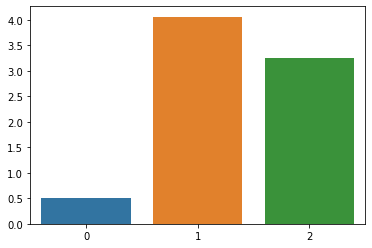

In [14]:
continuous_features = ['question_length', 'answer_length', 'response_time']
X_train_continuous = X_train[continuous_features]
X_train_continuous


anova_feature_names, anova_score_indices = plot_scores(X_train_continuous, y_train, select_k_best='all', score_func=f_classif)
print(f"anova feature names is: {anova_feature_names}\nanova score_indices is {anova_score_indices}")

### Dataset Filtering Based on Statistical Tests Performed on the Training Set

In [87]:
statistics = ['mi', 'chi2', 'anova']
feature_names = [mi_feature_names, chi2_feature_names, anova_feature_names]

dataset_samples = [X_train, X_val, X_test]
dataset_targets = [y_train, y_val, y_test]
dataset_names = ['train', 'val', 'test']

for stat_idx, statistic in enumerate(statistics):
    for dataset_idx, dataset_name in enumerate(dataset_names):
        dataset = dataset_samples[dataset_idx]
        target = dataset_targets[dataset_idx]
        feature_name = feature_names[stat_idx]
        pd.concat([dataset[feature_name], target], axis=1).to_csv(f'datasets/{dataset_names[dataset_idx]}_{statistics[stat_idx]}.csv', index=False)


In [3]:
DATASET_DIR = "datasets/"


def create_datasets(X_train, X_train_mi, X_train_chi2, labels):
    dataset_variants = ['all', 'mi', 'chi2']
    datasets = [X_train, X_train_mi, X_train_chi2]

    #TRAIN_RELEVANT_FEATURES_PATH = "train_relevant_features.csv"
    #TEST_RELEVANT_FEATURES_PATH = "test_relevant_features.csv"

    for idx, dataset in enumerate(datasets): 
        TRAIN_PATH = f"train_{dataset_variants[idx]}.csv"
        TEST_PATH = f"test_{dataset_variants[idx]}.csv"

        y_train_cpy = labels.copy(deep=True)



        X_train, X_test, y_train, y_test = train_test_split(dataset, y_train_cpy, random_state=0, stratify=y_train_cpy)
        X_train["is_helpful"] = y_train
        X_test["is_helpful"] = y_test
        X_train.to_csv(os.path.join(DATASET_DIR, TRAIN_PATH))
        X_test.to_csv(os.path.join(DATASET_DIR, TEST_PATH))



def plot_datasets(X_train, X_test):
    X_train["set"] = "train" 
    X_test["set"] = "test" 
    combined_datasets = pd.concat([X_train, X_test])
    plot_discrete_distributions(combined_datasets, continuous_features, hue="set")
    plot_continuous_distributions(combined_datasets, hue="set")

#create_datasets(X_train, X_train_mi, X_train_chi2, y_train)





In [15]:
X_train_all, X_test_all = pd.read_csv("datasets/train.csv"), pd.read_csv("datasets/test.csv")
X_train_mi, X_test_mi = pd.read_csv("datasets/train_mi.csv"), pd.read_csv("datasets/test_mi.csv")
X_train_chi2, X_test_chi2 = pd.read_csv("datasets/train_chi2.csv"), pd.read_csv("datasets/test_chi2.csv")

/home/jaipers5/.local/lib/python3.9/site-packages/seaborn/_core.py:1057: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  comp_col.loc[orig.index] = pd.to_numeric(axis.convert_units(orig))


ValueError: cannot reindex on an axis with duplicate labels

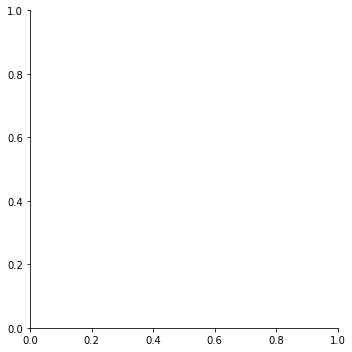

In [16]:
plot_datasets(X_train_all, X_test_all)

In [ ]:
plot_datasets(X_train_mi, X_test_mi)
# error since not all features are defined in these datasets

In [ ]:
plot_datasets(X_train_chi2, X_test_chi2)

In [13]:
final_data
private = final_data[final_data['is_private'] == True] 
private_helpful = private[private['is_helpful'] == True]
private_not_helpful = private[private['is_helpful'] == False]

public = final_data[final_data['is_private'] == False] 
public_helpful = public[public['is_helpful'] == True]
public_not_helpful = public[public['is_helpful'] == False]
#public = final_data[final_data['is_private'] == False]

positive = final_data[final_data['question_sentiment'] == 2.0] 
neutral = final_data[final_data['question_sentiment'] == 1.0] 
negative = final_data[final_data['question_sentiment'] == 0.0] 
# public_helpful = public[public['is_helpful'] == True]
# public_not_helpful = public[public['is_helpful'] == False]

#print(len(public_helpful))
#print(len(public_not_helpful))

#len(final_data[final_data['answerer_id'] == 5]) #1149
#len(final_data['answerer_id'])

print(len(positive))
print(len(neutral))
print(len(negative))

98
1915
1487


- response time bins
  - 0, 1, 5,10, 100, 200, 300, 400, ... , 1000, 2000, 3000, 4000, over 5000

In [17]:
a = [1,2,3,4,5]

for i in a:
    i+= 1

a

[1, 2, 3, 4, 5]